In [78]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from datetime import timedelta
from scipy.stats import levene
from scipy.stats import ttest_ind
from pingouin import normality
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest


In [2]:
# Retention – один из самых важных показателей в компании

# Напишу функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
# Данные имеют следующую структуру:

# registration_sample_data.csv - данные о времени регистрации
# authentification_sample_data.csv - данные о времени захода пользователей в игру

# Буду тестировать работу функции на сэмпле данных.

# Таблица с данными о времени регистрации

# Прочитаю этот датасет с разделителем ; и сразу создам копию данных для работы с ней, во избежание
# изменения исходного датасета

reg_data = pd.read_csv('registration_sample_data.csv', sep = ';')
reg_data_copy = reg_data.copy()
reg_data_copy.head()


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
# Переведу Unix-время в дату

reg_data_copy['reg_ts'] = pd.to_datetime(reg_data_copy['reg_ts'], unit='s')
reg_data_copy.head()


,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [4]:
reg_data_copy.shape

(1000000, 2)

In [5]:
# Следующая таблица - таблица с данными о времени захода пользователей в игру

# Прочитаю этот датасет с разделителем ; и сразу создам копию данных для работы с ней, во избежание
# изменения исходного датасета

auth_data = pd.read_csv('authentification_sample_data.csv', sep = ';')
auth_data_copy = auth_data.copy()
auth_data_copy.head()


,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
# Переведу Unix-время в дату

auth_data_copy['auth_ts'] = pd.to_datetime(auth_data_copy['auth_ts'], unit='s')
auth_data_copy.head()


,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [7]:
auth_data_copy.shape

(9601013, 2)

In [8]:
# Посмотрю, какой период данных охватывают наши данные

print(auth_data_copy.auth_ts.min())
print(auth_data_copy.auth_ts.max())

# Вижу, что период остаточно большой - 22 года, далее буду исследовать данные и решать, какой период взять 
# для расчёта retention

1998-11-18 09:43:43
2020-09-23 15:17:24


In [9]:
# Объединю датафреймы

reg_auth_data = reg_data_copy.merge(auth_data_copy, on = 'uid')
reg_auth_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [10]:
# Извлеку год и месяц для группировки (из данных о времени захода пользователей в игру)

reg_auth_data['auth_year'] = reg_auth_data['auth_ts'].dt.year
reg_auth_data['auth_month'] = reg_auth_data['auth_ts'].dt.to_period('M')

reg_auth_data.head()


,reg_ts,uid,auth_ts,auth_year,auth_month
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,1998,1998-11
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,1999,1999-07
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46,1999,1999-07
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15,1999,1999-07
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39,1999,1999-08


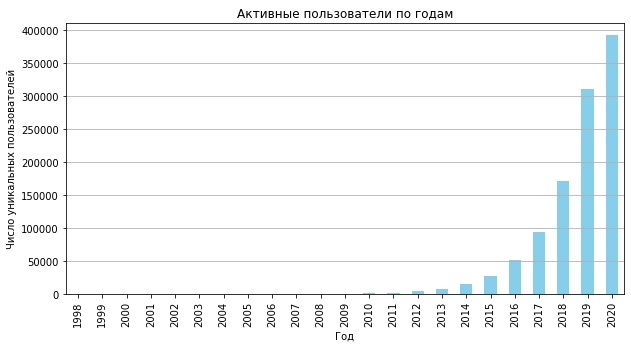

In [11]:
# Построю график активности по годам - считаю количество уникальных пользователей по годам

active_users_year = reg_auth_data.groupby('auth_year')['uid'].nunique()

plt.figure(figsize = (10, 5))
active_users_year.plot(kind = 'bar', color = 'skyblue')
plt.title('Активные пользователи по годам')
plt.xlabel('Год')
plt.ylabel('Число уникальных пользователей')
plt.grid(axis = 'y')
plt.show()


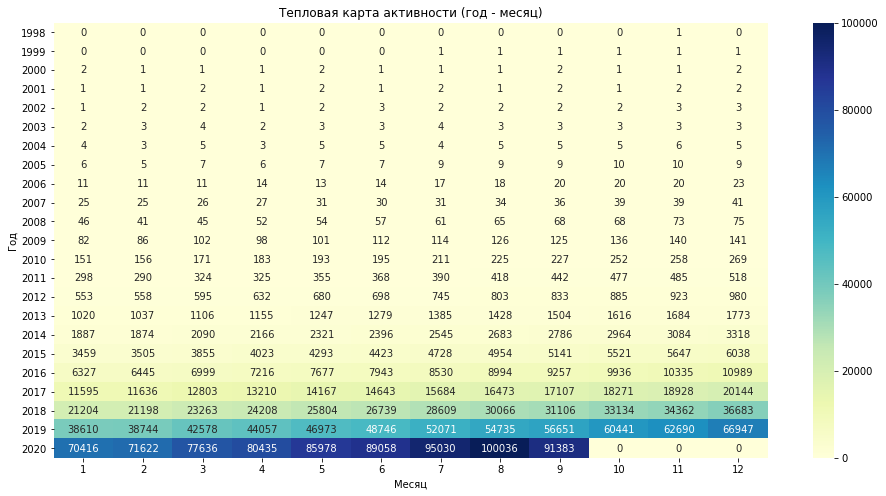

In [12]:
# Создам тепловую карту активности (год - месяц)

heatmap_data = reg_auth_data.pivot_table(
            index = 'auth_year',
            columns = reg_auth_data['auth_ts'].dt.month,
            values = 'uid',
            aggfunc = 'nunique',
            fill_value = 0)

plt.figure(figsize = (16, 8))
sns.heatmap(heatmap_data, cmap = 'YlGnBu', annot = True, fmt = 'd')
plt.title('Тепловая карта активности (год - месяц)')
plt.xlabel('Месяц')
plt.ylabel('Год')
plt.show()


In [13]:
# С помощью визуализации данных вижу, что пик активности пользователей приходится на последние 
# годы - возьму два последних года расчёта retention

# Но функцию можно изменить и считать retention за другие периоды


In [14]:
reg_auth_data.head()

,reg_ts,uid,auth_ts,auth_year,auth_month
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,1998,1998-11
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,1999,1999-07
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46,1999,1999-07
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15,1999,1999-07
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39,1999,1999-08


In [15]:
# Напишу функцию для расчёта дневного Retention для периода последних двух лет

def calculate_daily_retention_last_2_years(reg_auth_data, uid_col = 'uid', reg_col = 'reg_ts', auth_col = 'auth_ts'):
    
# Скопирую датасет во избежание изменения исходного датасета
    reg_auth_data_copy = reg_auth_data.copy()
    
# Определю период для анализа (последние 2 года)
    end_date = reg_auth_data_copy[reg_col].max()
    start_date = end_date - timedelta(days = 365 * 2)
    
# Фильтрую данные за период
    mask = (reg_auth_data_copy[reg_col] >= start_date) & (reg_auth_data_copy[reg_col] <= end_date)
    reg_auth_data_copy1 = reg_auth_data_copy[mask]
    
# Присваиваю когорты (месячные) на основе даты регистрации для каждого пользователя
    reg_auth_data_copy1['cohort'] = reg_auth_data_copy1[reg_col].dt.to_period('M')
    
# Вычисляю день относительно регистрации
    reg_auth_data_copy1['day'] = (reg_auth_data_copy1[auth_col] - reg_auth_data_copy1[reg_col]).dt.days
    
# Фильтрую первые 30 дней
    reg_auth_data_copy1 = reg_auth_data_copy1[reg_auth_data_copy1['day'].between(0, 30)]
    
# Создаю сводную таблицу для когортного анализа
    retention_counts = reg_auth_data_copy1.pivot_table(
        index = 'cohort',
        columns = 'day',
        values = uid_col,
        aggfunc = pd.Series.nunique,
        fill_value=0)
    
# Нормализую по размеру когорты (день 0)
    cohort_sizes = retention_counts[0]
    retention_rates = retention_counts.div(cohort_sizes, axis=0) * 100
    
# Строю тепловую карту когортного анализа
    plt.figure(figsize=(18, 18))
    plt.subplot(2, 1, 1)
    sns.heatmap(
        retention_rates,
        annot = True,
        fmt = '.1f',
        cmap = 'YlGnBu',
        vmin = 0,
        vmax = 100,
        cbar_kws = {'label': 'Retention (%)'})
    plt.title(f'Дневной Retention по месяцам ({start_date.date()} - {end_date.date()})')
    plt.xlabel('День после регистрации')
    plt.ylabel('Месяц регистрации')
    
    
    return retention_rates


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


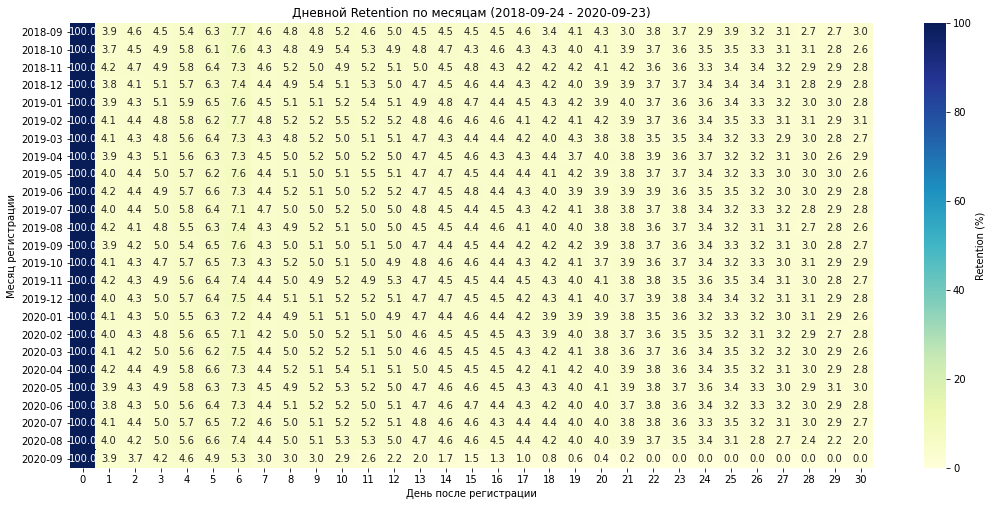

In [16]:
retention_results = calculate_daily_retention_last_2_years(reg_auth_data)
plt.show()


In [34]:
# В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определю, 
# какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

# На руках у нас результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных 
# предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 
# 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

# Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного 
# решения и как?

results_AB = pd.read_csv('AB_game', sep = ';')
results_AB_copy = results_AB.copy()
results_AB_copy.head()


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [35]:
# Для принятия решения о лучшем наборе акций нужно проанализировать ключевые метрики
# В качестве ключевых метрик возьму следующие: ARPU, конверсия в платящих, ARPPU


In [49]:
# Разделю на группы:

group_a = results_AB_copy[results_AB_copy['testgroup'] == 'a'] # контрольная группа
group_b = results_AB_copy[results_AB_copy['testgroup'] == 'b'] # тестовая группа


In [62]:
# Посчитаю количество наблюдений в тестовой и контрольной группах (это так же пригодится для выбора теста для 
# проверки статистической значимости)

a_count_of_users = group_a.user_id.count()
b_count_of_users = group_b.user_id.count()
print(a_count_of_users, b_count_of_users)

202103 202667


In [53]:
# Посчитаю ARPU в двух группах

a_arpu = group_a['revenue'].sum() / a_count_of_users
b_arpu = group_b['revenue'].sum() / b_count_of_users
print(a_arpu, b_arpu)


25.413719736965806 26.75128659327863


In [74]:
# Посчитаю конверсию в платящих в двух группах

a_conversion_to_paying = (((group_a['revenue'] > 0).sum())/ cnt_users_a) * 100
b_conversion_to_paying = (((group_b['revenue'] > 0).sum())/ cnt_users_b) * 100
print(a_conversion_to_paying, b_conversion_to_paying)
    

0.9539690157988748 0.8906235351586593


In [56]:
# Посчитаю ARPPU в двух группах

a_arppu = group_a[group_a['revenue'] > 0]['revenue'].mean()
b_arppu = group_b[group_b['revenue'] > 0]['revenue'].mean()
print(a_arppu, b_arppu)


2663.9984439834025 3003.6581717451522


In [75]:
# Создам датафрейм с посчитанными метриками для двух групп

data_for_metrics = {'metric': ['count_of_users', 'ARPU', 'conversion_to_paying', 'ARPPU'],
                   'group_a': [a_count_of_users, a_arpu, a_conversion_to_paying, a_arppu],
                   'group_b': [b_count_of_users, b_arpu, b_conversion_to_paying, b_arppu]}

df_metrics = pd.DataFrame(data_for_metrics, index=data_for_metrics['metric']).drop(columns='metric')
df_metrics

,group_a,group_b
count_of_users,202103.000000,202667.000000
ARPU,25.413720,26.751287
conversion_to_paying,0.953969,0.890624
ARPPU,2663.998444,3003.658172


In [38]:
# ARPU в тестовой группе вырос на 5%, но конверсия в платежи упала.
# Это означает, что меньше игроков платят, но каждый платящий приносит больше - что подтверждается данными


In [85]:
# Изучу наши распределения. Проверю выполнение условий на нормальность распределения выборки в двух наших группах

normality(data = results_AB_copy, dv = 'revenue', group = 'testgroup', method = 'normaltest')


,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


In [86]:
# Распределения ненормальны, но размеры выборок дают возможность использовать Т-тест для проверки стат.значимости


In [88]:
# ARPU буду проверять Т-тестом

# H0: ARPU в контрольной и тестовой группах не имеют стат.значимых различий
# H1: ARPU тестовой группы стат.значимо выше

stat, p_value = ttest_ind(group_a['revenue'], group_b['revenue'])
print(stat, p_arpu)

# Не могу отвергнуть нулевую гипотезу - значение p-value более 0,05 -> различия ARPU в контрольной и 
# тестовой группах не имеют стат.значимых различий, наблюдаемая разница между группами может быть случайной


-0.6242026493616787 0.532494858971837


In [89]:
# ARPPU буду проверять Т-тестом

# H0: ARPPU в контрольной и тестовой группах не имеют стат.значимых различий
# H1: ARPPU тестовой группы стат.значимо выше
           
stat, p_value = ttest_ind(results_AB_copy.query("testgroup == 'a' & revenue > 0")['revenue'], results_AB_copy.query("testgroup == 'b' & revenue > 0")['revenue'])
print(stat, p_value)

# Не могу отвергнуть нулевую гипотезу - значение p-value более 0,05 -> различия ARPPU в контрольной и 
# тестовой группах не имеют стат.значимых различий, наблюдаемая разница между группами может быть случайной


-1.5917100176862002 0.11153459157259504


In [87]:
# Конверсию в платящих буду проверять z-тестом

# Н0: Конверсия в платящих в контрольной и тестовой группах не имеют стат.значимых различий
# Н1: Конверсия в контрольной группе выше, чем в тестовой

# Отбор данных

paying_a = (group_a['revenue'] > 0).sum()
paying_b = (group_b['revenue'] > 0).sum()

paying_users = [paying_a, paying_b] # платящие пользователи
users = [a_count_of_users, b_count_of_users] # всего пользователей

# Проведение z-test
z_stat, p_value = proportions_ztest(count = pay, nobs = users)

print(z_stat, p_value)

# Не могу отвергнуть нулевую гипотезу - значение p-value менее 0,05 -> различия в конверсиях в контрольной и 
# тестовой группах - статически значимые


2.108028495889841 0.035028524642854865


In [90]:
# Выводы: 

# ARPU и ARPPU в тестовой группе выше, чем в контрольной (это могло бы говорить о том, что в тестовой группе 
# пользователи больше тратят), но при этом разница в значениях не имеет стат.значимых различий -> делаю вывод:
# наблюдаемая разница между группами может быть случайной и не говорит о том, что при новых условиях
# пользователи платят больше

# При этом контрольная группа показывает более высокую конверсию в платящих пользователей (возможно набор
# акций, предложенный контрольной группе, более привлекателен для пользователей). Разница в значениях имеет стат.
# различия -> предположение верно. При этом уменьшение числа платящих пользователей — негативный сигнал

# Таким образом контрольная группа (текущие наборы акционных предложений) предпочтительнее, потому что:

# Есть стабильная конверсия в платежи (0.95% vs 0.89%)
# Нет доказательств, что рост ARPU и ARPPU в тестовой группе — не случайность
# Есть риск потерять часть платящих пользователей
